In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [35]:
pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


 we individually take each file and parse into xml.etree and find the object -> bndbox. Then we extract xmin,xmax,ymin,ymax and saved those values in the dictionary. After we convert it into a pandas data frame and save that into CSV file and save it in project folder as shown below.

In [2]:
#Reading the xml files
path = glob("D:/Devi/Singularis Software Technologies/numberplate_detection/annotations/*.xml")

labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)

In [5]:
df.to_csv('labels.csv',index=False)
df.head()


filepath  xmin  xmax  ymin  ymax
0  D:/Devi/Singularis Software Technologies/numbe...   226   419   125   173
1  D:/Devi/Singularis Software Technologies/numbe...   134   262   128   160
2  D:/Devi/Singularis Software Technologies/numbe...   140   303     5   148
3  D:/Devi/Singularis Software Technologies/numbe...   175   214   114   131
4  D:/Devi/Singularis Software Technologies/numbe...   167   240   202   220

we successfully extract the diagonal position of each image and convert the data from an unstructured to a structured format

Now also extract the respective image filename of the XML.



In [6]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join("D:/Devi/Singularis Software Technologies/numberplate_detection/images",filename_image)
    return filepath_image
getFilename(filename)


'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars0.png'

In [7]:
# random check
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars0.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars1.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars10.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars100.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars101.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars102.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars103.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars104.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars105.png',
 'D:/Devi/Singularis Software Technologies/numberplate_detection/images\\Cars106.png']

### VERIFY THE DATA
As till now we did the manual process it is important to verify the information is we got is valid or not. For that just verify the bounding box is appearing properly for a given image. Here I consider the image car10.jpeg and the corresponding diagonal position can found in df

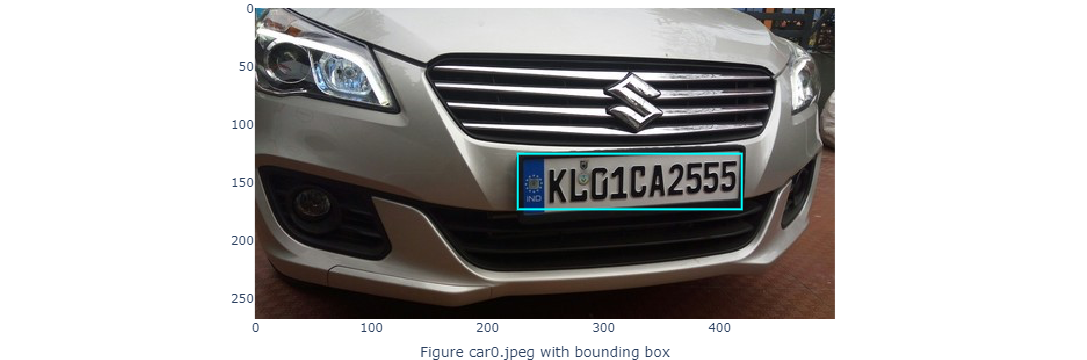

In [42]:
file_path = image_path[0] #path of our image Car0.jpeg
img = cv2.imread(file_path) #read the image
# 226</xmin>125</ymin>419</xmax><ymax>173 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=500, height=268, margin=dict(l=1, r=1, b=1, t=1),xaxis_title='Figure car0.jpeg with bounding box')
fig.add_shape(type='rect',x0=226, x1=419, y0=125, y1=173, xref='x', yref='y',line_color='cyan')

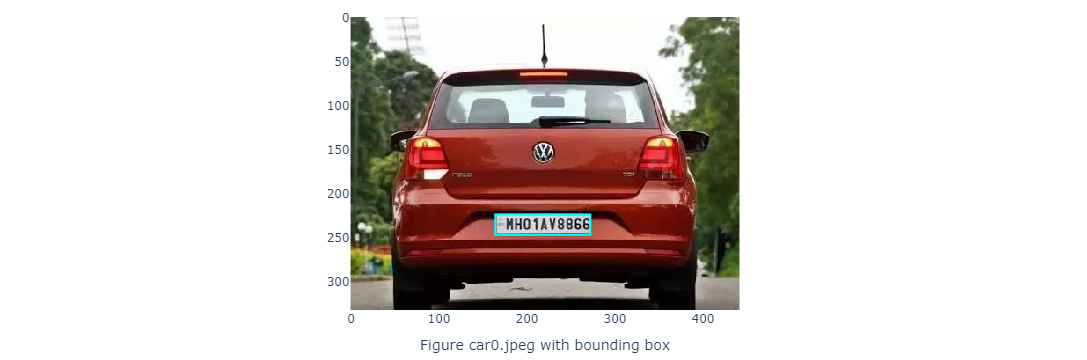

In [45]:
file_path = image_path[11] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
 
# <xmin>131</xmin><ymin>206</ymin> <xmax>273</xmax> <ymax>234</ymax>

img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=400, height=305, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure car0.jpeg with bounding box')
fig.add_shape(type='rect',x0=164, x1=272, y0=224, y1=247, xref='x', yref='y',line_color='cyan')

### Pre processing
This is a very important step, in this process we will take each and every image and convert it into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning mode

In [8]:
# Pre processing

labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

After that, we will normalize the image just by dividing with maximum number as we know that the maximum number for an 8-bit image is 28 -1 = 255. That the reason we will divide our image 255.0. The way of diving an array with the maximum value is called Normalization (Min-Max Scaler). We also need to normalize our labels too. Because for the deep learning model the output range should be between 0 to 1. For normalizing labels, we need to divide the diagonal points with the width and height of the image. And finally values in a python list.

### Splitting

In [9]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)


In [10]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

In [11]:
from keras.models import load_model, Sequential
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,951,108
Trainable params: 3,236,420
Non

In [12]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [13]:
r = model.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_test,y_test),verbose=1)

Epoch 1/50
11/11 [==============================] - 67s 6s/step - loss: 0.0789 - accuracy: 0.4191 - val_loss: 0.0583 - val_accuracy: 0.4828
Epoch 2/50
11/11 [==============================] - 70s 6s/step - loss: 0.0581 - accuracy: 0.4480 - val_loss: 0.0484 - val_accuracy: 0.4828
Epoch 3/50
11/11 [==============================] - 69s 6s/step - loss: 0.0503 - accuracy: 0.4480 - val_loss: 0.0416 - val_accuracy: 0.4828
Epoch 4/50
11/11 [==============================] - 74s 7s/step - loss: 0.0473 - accuracy: 0.4480 - val_loss: 0.0423 - val_accuracy: 0.4828
Epoch 5/50
11/11 [==============================] - 73s 7s/step - loss: 0.0466 - accuracy: 0.4480 - val_loss: 0.0414 - val_accuracy: 0.4828
Epoch 6/50
11/11 [==============================] - 81s 8s/step - loss: 0.0461 - accuracy: 0.4480 - val_loss: 0.0414 - val_accuracy: 0.4828
Epoch 7/50
11/11 [==============================] - 77s 7s/step - loss: 0.0462 - accuracy: 0.4480 - val_loss: 0.0415 - val_accuracy: 0.4828
Epoch 8/50
11/11 [==

### Deep Learning Model 
### Inception-ResNet V2

In [14]:
model.save('./object_detection1.h5')

In [15]:
model = tf.keras.models.load_model('./object_detection1.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [39]:
path = 'D:/Devi/Singularis Software Technologies/numberplate_detection/images/Cars0.png'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 268
Width of the image = 500


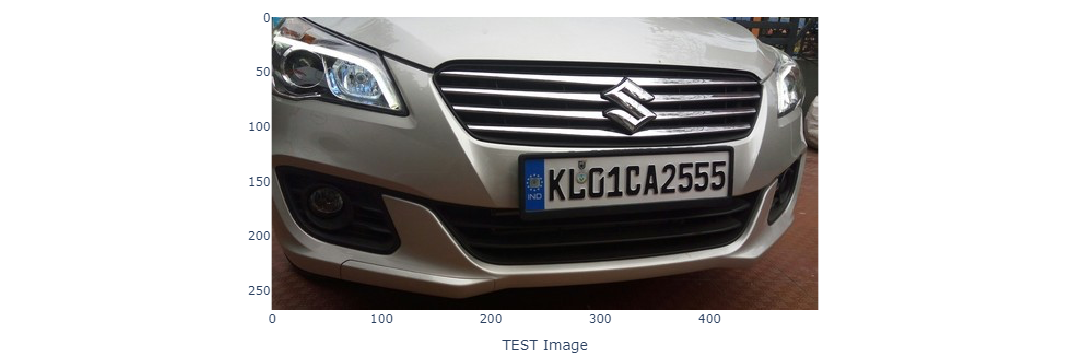

In [40]:
fig = px.imshow(image)
fig.update_layout(width=500, height=268,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='TEST Image')

In [18]:
image_arr_224.shape

(224, 224, 3)

But in order to pass this image of a model, we need to provide the data in the dynamic fourth dimension. And what one indicates is a number of images. So here we are just passing only one image

In [19]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [20]:
# Make predictions
coords = model.predict(test_arr)
coords


1/1 [==============================] - 0s 406ms/step


array([[0.47021484, 0.8722436 , 0.44187853, 0.63441986]], dtype=float32)

We have got the output from the model and output what we got is the normalized output. So, what we need to do is to convert back into our original form values, which actually we did in during the training process, in the training process, we have the original form values and convert that normalized one. So basically, we will de-normalize the values back.

In [21]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[235.10742188, 436.1217916 , 118.42344534, 170.02452207]])

#### BOUNDING BOX
Now we will draw bounding box on top of the image. I just want to provide the two diagonal points. Let's make use of these points and let's draw the rectangle box.

In [22]:
coords = coords.astype(np.int32)
coords

array([[235, 436, 118, 170]])

These are the coordinates of our numberplate in the test image

In [23]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(235, 118) (436, 170)


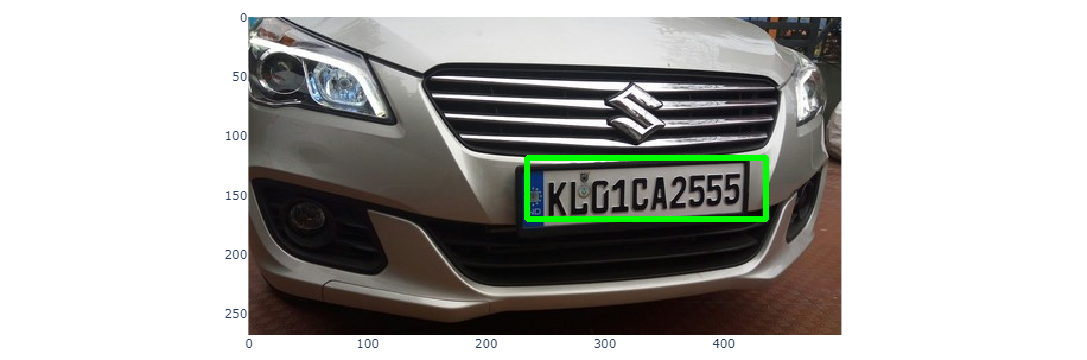

In [24]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=500, height=268, margin=dict(l=10, r=10, b=10, t=10))

In [25]:
# cropping the number plate

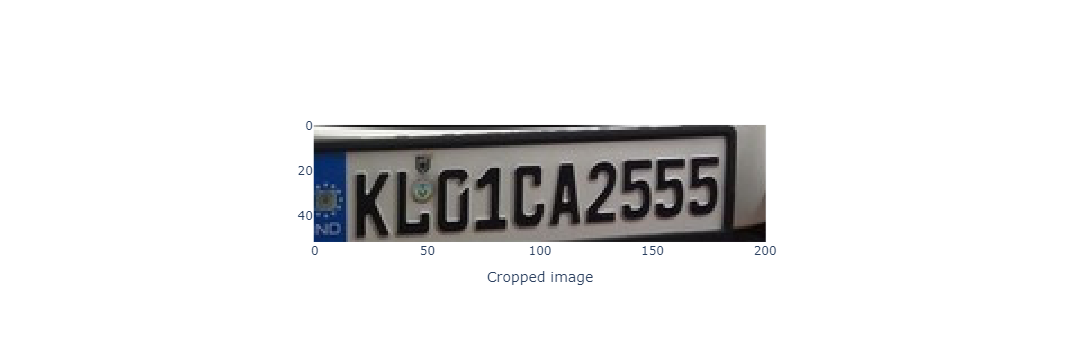

In [28]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = coords[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Cropped image')

Height of the image = 300
Width of the image = 400


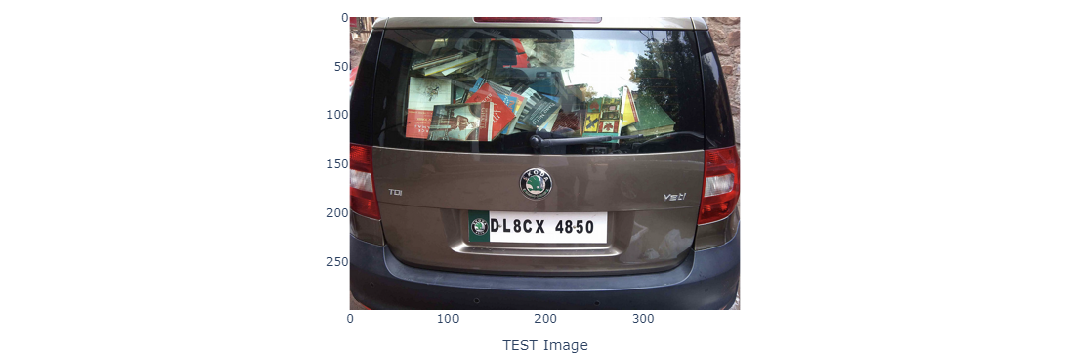

In [46]:
path = 'D:/Devi/Singularis Software Technologies/numberplate_detection/images/Cars150.png'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)
fig = px.imshow(image)
fig.update_layout(width=500, height=268,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='TEST Image')

In [60]:
image_arr_224.shape
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape
# Make predictions
coords1 = model.predict(test_arr)
coords1
denorm = np.array([w,w,h,h])
coords1 = coords1 * denorm
coords1
coords1 = coords1.astype(np.int32)
coords1


1/1 [==============================] - 0s 175ms/step


array([[115, 276, 198, 238]])

(115, 198) (276, 238)


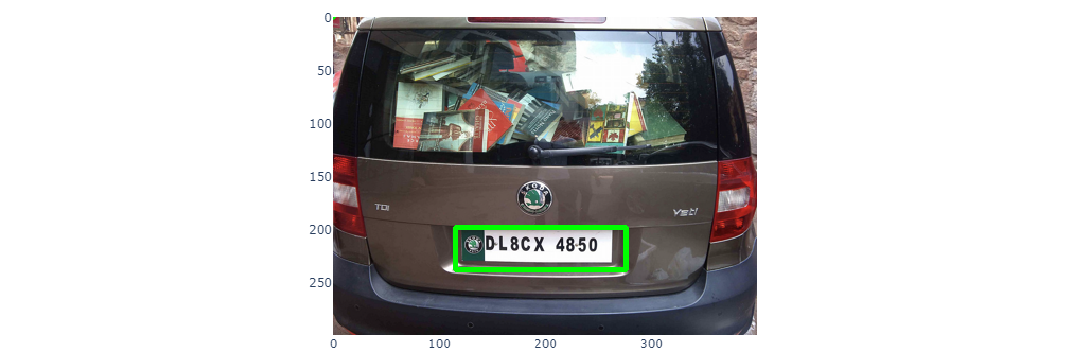

In [61]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords1[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=400, height=300, margin=dict(l=10, r=10, b=10, t=10))

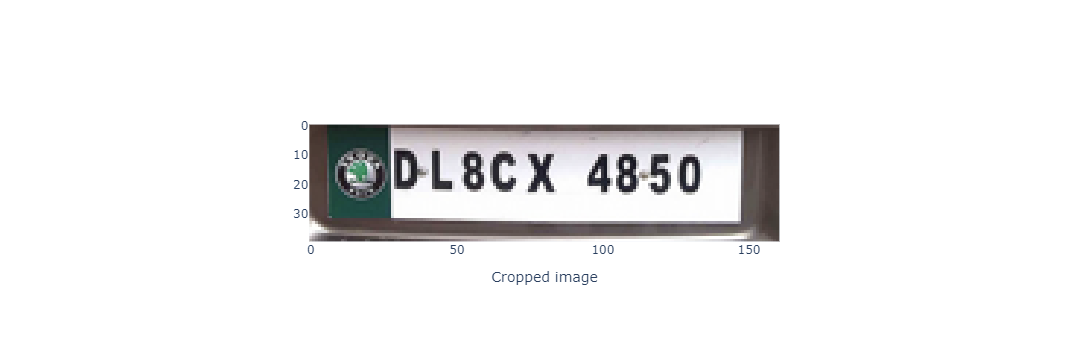

In [63]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = coords1[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Cropped image')

In [37]:
# extracting the string
# text = pt.image_to_string(roi)
# print(text)